In [1]:
import os
from pathlib import Path
from math import pi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import (KFold, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.tree import DecisionTreeClassifier

train_dir = Path('./data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('./data/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('./data/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

aug_dir = Path('./data/augmented/')
aug_filepaths = list(aug_dir.glob(r'**/*.jpg')) + list(aug_dir.glob(r'**/*.jpeg'))

data = train_filepaths + test_filepaths + val_filepaths

In [2]:
def paths_to_dataframe(path):
    labels = []
    for i in range(len(path)):
        labels.append(str(path[i]).split(os.sep)[-2])

    labels = pd.Series(labels, name='Label')
    path = pd.Series(path, name='Path').astype(str)

    df = pd.concat([path, labels], axis=1)

    df = df.sample(frac=0.5).reset_index(drop = True)

    return df
    
data_df = paths_to_dataframe(data)

In [3]:
data_df = data_df.sample(frac=1, random_state=42)
data_df.shape

(1725, 2)

In [4]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X = np.array(data_df['Path'])
y = np.array(data_df['Label'])

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    classification_rep = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(classification_rep)

    classes = np.unique(y_test)
    class_accuracy = {}
    for cls in classes:
        indices = np.where(y_test == cls)[0]
        class_accuracy[cls] = accuracy_score(y_test[indices], np.array(y_pred)[indices])

    file_path = './wynik.txt'
    with open(file_path, 'a') as file:
        file.write(str(accuracy))
        file.write('\n')
        file.write(str(precision))
        file.write('\n\n')


    return accuracy, precision, recall, f1, class_accuracy

In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

In [7]:
def sort_classes_by_gini_index(X_train, y_train):
    unique_labels = np.unique(y_train)
    gini_indices_per_class = {label: 0 for label in unique_labels}

    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)

    feature_importances = tree.feature_importances_
    sorted_features = np.argsort(feature_importances)[::-1]  # Sort descending by feature importances

    for label in unique_labels:
        indices = np.where(y_train == label)[0]
        gini_indices_per_class[label] = np.mean(feature_importances[sorted_features[:len(indices)]]) if len(indices) > 0 else 0

    sorted_labels = sorted(unique_labels, key=lambda label: gini_indices_per_class[label], reverse=True)
    return sorted_labels

In [8]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

def nested_dichotomy_without_removing(X_train, y_train, X_test):
    unique_labels = sort_classes_by_gini_index(X_train, y_train)
    classifiers = []

    for i in unique_labels:
        y_binary = np.where(y_train == i, 1, 0)
        tree = DecisionTreeClassifier()
        tree.fit(X_train, y_binary)
        classifiers.append((tree, i))

        print(i)

    predictions = []
    for tree, positive_label in classifiers:
        binary_prediction = tree.predict(X_test)
        predictions.append(np.where(binary_prediction == 1, positive_label, None))

    results = [None for _ in range(len(X_test))]
    for i in range(len(predictions)):
        for j in range(len(X_test)):
            if predictions[i][j] is not None and results[j] == None:
                results[j] = unique_labels[i]

    for i in range(len(results)):
        if results[i] is None:
            results[i] = unique_labels[0]
        

    return results, predictions, classifiers

In [9]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

def nested_dichotomy_with_removing(X_train, y_train, X_test):
    unique_labels = sort_classes_by_gini_index(X_train, y_train)
    classifiers = []

    for i in unique_labels:
        y_binary = np.where(y_train == i, 1, 0)
        tree = DecisionTreeClassifier()
        tree.fit(X_train, y_binary)
        classifiers.append((tree, i))

        indices_to_remove = np.where(y_train == i)[0]
        X_train = np.delete(X_train, indices_to_remove, axis=0)
        y_train = np.delete(y_train, indices_to_remove)

        print(i, '   removing')
        print(X_train.shape)

    predictions = []
    for tree, positive_label in classifiers:
        binary_prediction = tree.predict(X_test)
        predictions.append(np.where(binary_prediction == 1, positive_label, None))

    results = [None for _ in range(len(X_test))]
    for i in range(len(predictions)):
        for j in range(len(X_test)):
            if predictions[i][j] is not None and results[j] == None:
                results[j] = unique_labels[i]

    for i in range(len(results)):
        if results[i] is None:
            results[i] = unique_labels[0]

    return results, predictions, classifiers

In [10]:
from tensorflow.keras.applications import VGG16
vgg16_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
X_ext = np.array([extract_features(img_path, vgg16_model) for img_path in X])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━

In [11]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from tensorflow.keras.applications import MobileNetV2


def experiment_loop():

    scores = [[] for _ in range(k)]
    scores_rem = [[] for _ in range(k)]

    # mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
    # X_ext = np.array([extract_features(img_path, mobilenet_model) for img_path in X])

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X_ext[train_index], X_ext[val_index]
        y_train, y_val = y[train_index], y[val_index]

        results, pred, models = nested_dichotomy_without_removing(X_train, y_train, X_val)
        results_rem, pred_rem, models_rem = nested_dichotomy_with_removing(X_train, y_train, X_val)
        accuracy, precision, recall, f1, class_accuracy = metrics(y_val, results)
        accuracy_rem, precision_rem, recall_rem, f1_rem, class_accuracy = metrics(y_val, results_rem)
        scores[fold].append((accuracy, precision, recall, f1, class_accuracy))
        scores_rem[fold].append((accuracy_rem, precision_rem, recall_rem, f1_rem, class_accuracy))

    return scores, scores_rem

scores, scores_rem = experiment_loop()

orange
kiwi
raddish
lemon
ginger
apple
banana
jalepeno
onion
pomegranate
cauliflower
mango
tomato
potato
garlic
grapes
watermelon
beetroot
chilli pepper
eggplant
pear
sweetpotato
paprika
turnip
corn
pineapple
spinach
bell pepper
capsicum
cucumber
peas
carrot
lettuce
soy beans
cabbage
sweetcorn
orange    removing
(1357, 512)
kiwi    removing
(1332, 512)
raddish    removing
(1305, 512)
lemon    removing
(1275, 512)
ginger    removing
(1243, 512)
apple    removing
(1209, 512)
banana    removing
(1175, 512)
jalepeno    removing
(1141, 512)
onion    removing
(1107, 512)
pomegranate    removing
(1073, 512)
cauliflower    removing
(1038, 512)
mango    removing
(1003, 512)
tomato    removing
(968, 512)
potato    removing
(932, 512)
garlic    removing
(894, 512)
grapes    removing
(856, 512)
watermelon    removing
(818, 512)
beetroot    removing
(779, 512)
chilli pepper    removing
(740, 512)
eggplant    removing
(701, 512)
pear    removing
(662, 512)
sweetpotato    removing
(623, 512)
paprika 

Average Class Accuracy for Nested Dichotomy Without Removing : {'apple': 0.48686868686868684, 'banana': 0.582857142857143, 'beetroot': 0.442965367965368, 'bell pepper': 0.4061172161172161, 'cabbage': 0.6909228026875085, 'capsicum': 0.37148586707410236, 'carrot': 0.4909090909090909, 'cauliflower': 0.802034632034632, 'chilli pepper': 0.412987012987013, 'corn': 0.486060606060606, 'cucumber': 0.5658333333333333, 'eggplant': 0.5590909090909091, 'garlic': 0.33333333333333337, 'ginger': 0.518888888888889, 'grapes': 0.35452991452991456, 'jalepeno': 0.45396825396825397, 'kiwi': 0.6094117647058823, 'lemon': 0.4067765567765568, 'lettuce': 0.5274747474747474, 'mango': 0.4323809523809524, 'onion': 0.491965811965812, 'orange': 0.5774891774891775, 'paprika': 0.36753246753246754, 'pear': 0.5334310134310134, 'peas': 0.30170940170940175, 'pineapple': 0.6216161616161616, 'pomegranate': 0.6245238095238096, 'potato': 0.46302521008403363, 'raddish': 0.3821428571428571, 'soy beans': 0.5320202020202021, 'spin

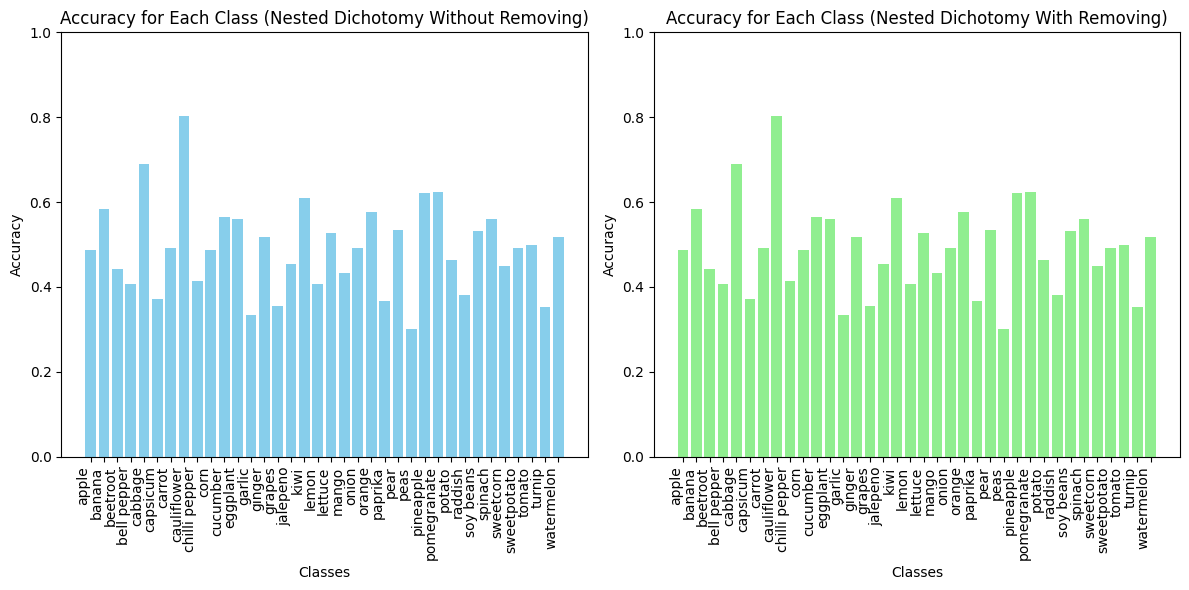

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from scipy.stats import ttest_rel

param_methods = ['Nested Dichotomy Without Removing', 'Nested Dichotomy With Removing']

class_accuracies = [[fold[0][-1] for fold in scores], [fold[0][-1] for fold in scores_rem]]
sum_class_accuracy = [{key: 0 for key in class_accuracies[model_idx][0].keys()} for model_idx in range(len(class_accuracies))]


for model_idx, model_accuracies in enumerate(class_accuracies):
    for fold in model_accuracies:
        for key, value in fold.items():
            if key in sum_class_accuracy[model_idx]:
                sum_class_accuracy[model_idx][key] += value


num_folds = len(scores)


avg_class_accuracy = [{key: value / num_folds for key, value in sum_accuracies.items()} for sum_accuracies in sum_class_accuracy]


for model_idx, method_name in enumerate(param_methods):
    print("Average Class Accuracy for", method_name, ":", avg_class_accuracy[model_idx])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(avg_class_accuracy[0].keys(), avg_class_accuracy[0].values(), color='skyblue')
plt.title('Accuracy for Each Class (' + param_methods[0] + ')')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(avg_class_accuracy[1].keys(), avg_class_accuracy[1].values(), color='lightgreen')
plt.title('Accuracy for Each Class (' + param_methods[1] + ')')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


Average Accuracy for Nested Dichotomy Without Removing: 0.4585507246376812
Average Precision for Nested Dichotomy Without Removing: 0.6310647556273787
Average Recall for Nested Dichotomy Without Removing: 0.4585507246376812
Average F1-Score for Nested Dichotomy Without Removing: 0.49903287481137876
Average Accuracy for Nested Dichotomy With Removing: 0.4898550724637681
Average Precision for Nested Dichotomy With Removing: 0.5341981000408783
Average Recall for Nested Dichotomy With Removing: 0.4898550724637681
Average F1-Score for Nested Dichotomy With Removing: 0.4935921636252581


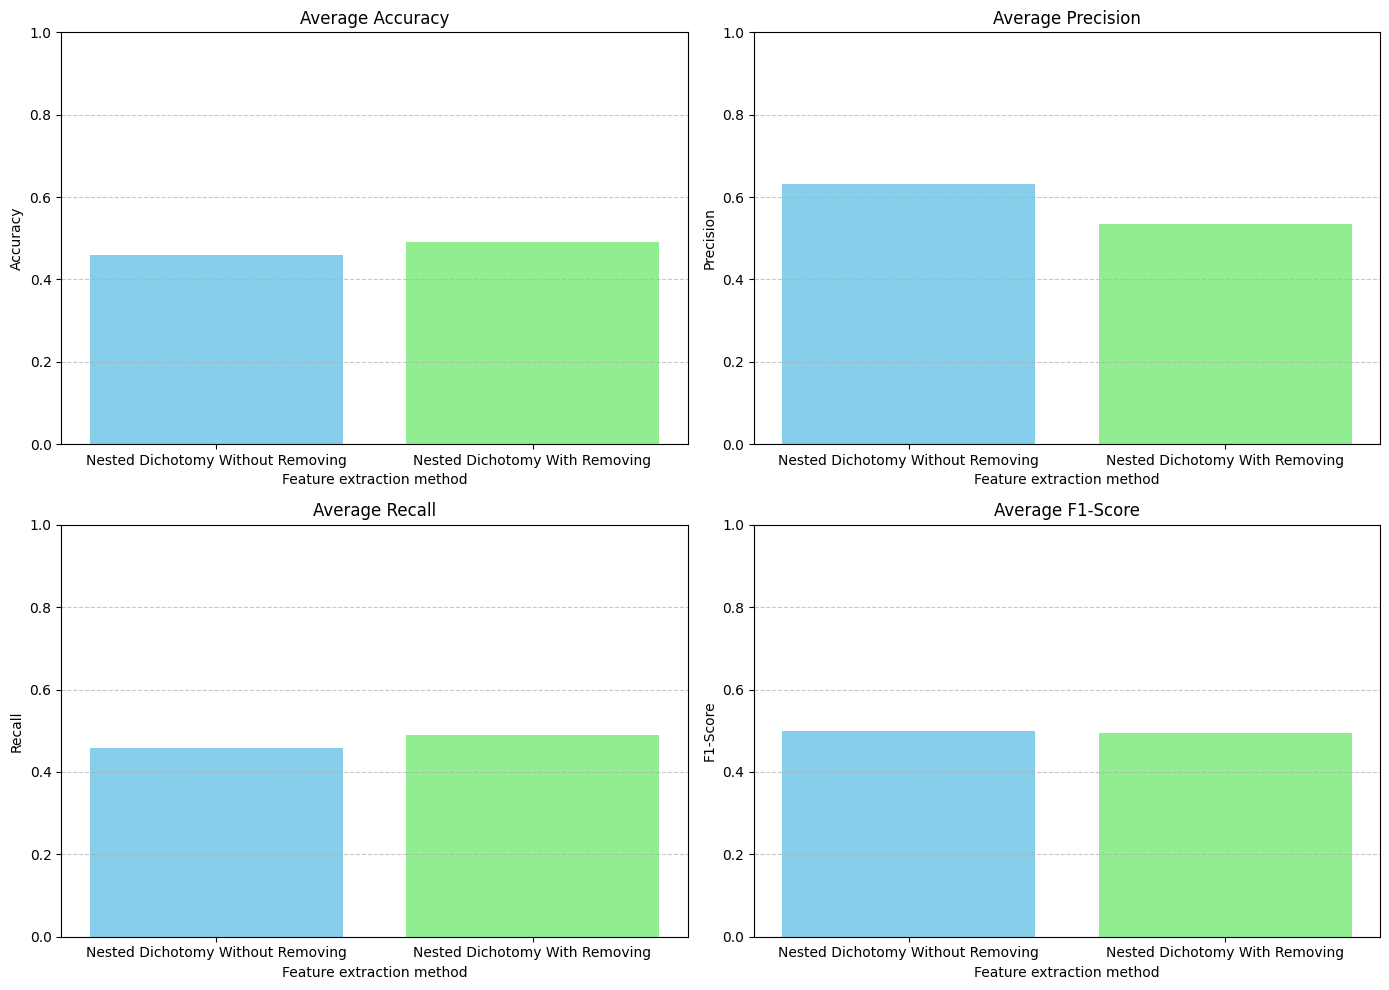

In [13]:
avg_accuracy = []
avg_precision = []
avg_recall = []
avg_f1 = []


for idx, method_name in enumerate(param_methods):

    method_scores = scores if idx == 0 else scores_rem

    accuracy = [score[0][0] for score in method_scores]
    precisions = [score[0][1] for score in method_scores]
    recalls = [score[0][2] for score in method_scores]
    f1_scores = [score[0][3] for score in method_scores]

    avg_accuracy.append(np.mean(accuracy))
    avg_precision.append(np.mean(precisions))
    avg_recall.append(np.mean(recalls))
    avg_f1.append(np.mean(f1_scores))


for idx, method_name in enumerate(param_methods):
    print("Average Accuracy for", method_name + ":", avg_accuracy[idx])
    print("Average Precision for", method_name + ":", avg_precision[idx])
    print("Average Recall for", method_name + ":", avg_recall[idx])
    print("Average F1-Score for", method_name + ":", avg_f1[idx])


plt.figure(figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [avg_accuracy, avg_precision, avg_recall, avg_f1]

for i in range(len(metrics)):
    plt.subplot(2, 2, i+1)
    plt.bar(param_methods, values[i], color=['skyblue', 'lightgreen'])
    plt.title('Average ' + metrics[i])
    plt.xlabel('Feature extraction method')
    plt.ylabel(metrics[i])
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [14]:
def compare_methods(method1, name1, method2, name2):
    t_statistic, p_value = ttest_rel(method1, method2)
    comparison = f"{name1} is better than {name2}" if t_statistic > 0 else f"{name2} is better than {name1}"
    significance = "significant" if p_value < 0.05 else "not significant"
    return t_statistic, p_value, comparison, significance


methods = param_methods
values = [avg_accuracy, avg_precision, avg_recall, avg_f1]

pairs = combinations(enumerate(methods), 2)


for pair in pairs:
    (idx_1, name_1), (idx_2, name_2) = pair
    t_statistic, p_value, comparison, significance = compare_methods(values[idx_1], name_1, values[idx_2], name_2)
    print(f'{name_1} vs. {name_2}:')
    print(f'T-statistic: {t_statistic}')
    print(f'P-value: {p_value}')
    print(f'Result: {comparison} (p-value {significance})')


Nested Dichotomy Without Removing vs. Nested Dichotomy With Removing:
T-statistic: -1.691935404989666
P-value: 0.33983053579663636
Result: Nested Dichotomy With Removing is better than Nested Dichotomy Without Removing (p-value not significant)


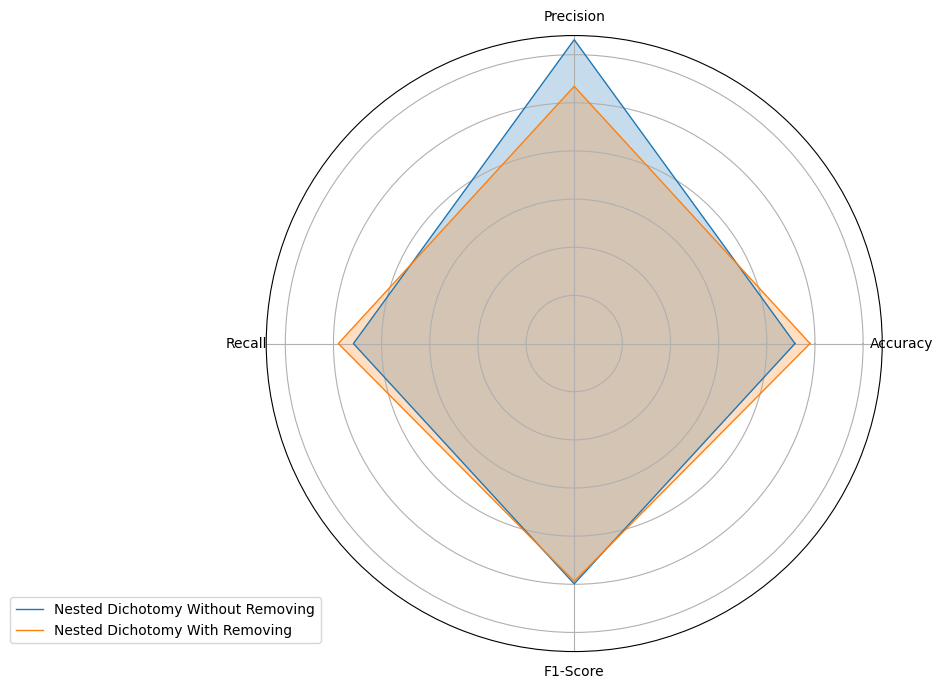

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar_chart(methods, avg_accuracy, avg_precision, avg_recall, avg_f1, metrics):
    num_features = 4
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for method, avg_acc, avg_prec, avg_rec, avg_f in zip(methods, avg_accuracy, avg_precision, avg_recall, avg_f1):
        values = [avg_acc, avg_prec, avg_rec, avg_f, avg_acc]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=method)
        ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_yticklabels([])

    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.show()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
plot_radar_chart(param_methods, avg_accuracy, avg_precision, avg_recall, avg_f1, metrics)
